## Analysis of historical data of IPC levels
For this analysis we use two sources of IPC levels, those produced by FewsNet (https://fews.net) and those producted by Global IPC (http://www.ipcinfo.org).   
FewsNet has produced these analyses since 2009. Global IPC is a more recent initiative where the timing and coverage of the analysis depends on the country. For Ethiopia currently (Oct 2020) two analyses have been done, one in 2019 and one in 2020. 

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from datetime import timedelta
import matplotlib.dates as dates
from sklearn.metrics import accuracy_score
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import os
import sys
path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
sys.path.append(path_mod)
from indicators.food_insecurity.config import Config

In [3]:
country="ethiopia"
admin_level=1
#suffix of filenames
suffix=""
config=Config()
parameters = config.parameters(country)
country_folder = os.path.join(config.DIR_PATH, config.ANALYSES_DIR, country)
adm1_bound_path= os.path.join(country_folder,config.DATA_DIR,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])
fnwp_dir = os.path.join(country_folder, config.DATA_DIR, config.FEWSWORLDPOP_PROCESSED_DIR)
fnwp_path = os.path.join(fnwp_dir,config.FEWSWORLDPOP_PROCESSED_FILENAME.format(country=country,admin_level=admin_level,suffix=suffix))

#### Load FewsNet data

In [4]:
df_fadm=pd.read_csv(fnwp_path)
df_fadm.date=pd.to_datetime(df_fadm.date)

In [5]:
#these are updates without new CS data, remove for cleanness
df_fadm=df_fadm[~df_fadm.date.isin(["2020-08-01","2020-09-01"])]

In [6]:
df_fadm["date"]=pd.to_datetime(df_fadm["date"])

In [7]:
df_fnat=pd.read_csv(os.path.join(fnwp_dir,config.FEWSWORLDPOP_PROCESSED_FILENAME.format(country=country,admin_level=0,suffix=suffix)))

In [8]:
#these are updates without new CS data, remove for cleanness
df_fnat=df_fnat[~df_fnat.date.isin(["2020-08-01","2020-09-01"])]

In [9]:
df_fnat["date"]=pd.to_datetime(df_fnat["date"])

##### Check for missing data

In [10]:
print("Number of date-admin1 combinations with no IPC CS data:", len(df_fadm[df_fadm.pop_CS==0]))

Number of date-admin1 combinations with no IPC CS data: 0


In [11]:
print("Percentage of missing data:",len(df_fadm[df_fadm.pop_CS==0])/len(df_fadm)*100)

Percentage of missing data: 0.0


#### Load Global IPC data

In [12]:
globalipc_dir=os.path.join(country_folder,config.DATA_DIR, config.GLOBALIPC_PROCESSED_DIR)
globalipc_path=os.path.join(globalipc_dir,f"{country}_globalipc_admin{admin_level}{suffix}.csv")

In [13]:
df_gadm=pd.read_csv(globalipc_path)

In [14]:
df_gadm["date"]=pd.to_datetime(df_gadm["date"])
df_gadm["year"]=df_gadm["date"].dt.year
df_gadm["month"]=df_gadm["date"].dt.month

In [16]:
glob_adm1c="ADMIN1"

In [18]:
#group to country
df_gnat=pd.read_csv(os.path.join(globalipc_dir,f"{country}_globalipc_admin0{suffix}.csv"))

In [19]:
df_gnat["date"]=pd.to_datetime(df_gnat["date"])

In [20]:
df_gnat.loc[df_gnat["date"]=="2019-09-01","pop_total_CS"]=df_fnat.loc[df_fnat["date"]=="2019-10-01","pop_total_CS"].values
df_gnat.loc[df_gnat["date"]=="2020-08-01","pop_total_CS"]=df_fnat.loc[df_fnat["date"]=="2020-10-01","pop_total_CS"].values
df_gnat.loc[df_gnat["date"]=="2020-10-01","pop_total_CS"]=df_fnat.loc[df_fnat["date"]=="2020-10-01","pop_total_CS"].values

### Analysis of historical IPC values
To get a better understanding of the country's typical values and history, both on national and admin1 level

In [96]:
def plot_ipclevels(df,adm1c="ADMIN1",pop_col="pop_total_CS",status="CS",perc=False,figsize=(30,30),width=75,title=None):
    color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
    
#     width = 75
    count = 1
    fig, ax = plt.subplots(figsize=figsize)
    if perc:
        perc_str="perc_"
    else:
        perc_str=""
    if f"{perc_str}{status}_12" not in df.columns:
        df[f"{perc_str}{status}_12"]=df[f"{perc_str}{status}_1"]+df[f"{perc_str}{status}_2"]
    for region in df[adm1c].unique():
        ax = plt.subplot(6,2,count)
        df_c=df.copy()
        data = df_c.loc[df_c[adm1c]==region,:]
        
        p4 = plt.bar(data['date'], data[f'{perc_str}{status}_5'], width=width, color=color_map[5],label="IPC 5")
        p4 = plt.bar(data['date'], data[f'{perc_str}{status}_4'], width=width, color=color_map[4],label="IPC 4")
        p3 = plt.bar(data['date'], data[f'{perc_str}{status}_3'], width=width, color=color_map[3], bottom=(data[f'{perc_str}{status}_4']+data[f'{perc_str}{status}_5']).to_numpy(),label="IPC 3")
        p2 = plt.bar(data['date'], data[f'{perc_str}{status}_12'], width=width, color=color_map[1], bottom=(data[f'{perc_str}{status}_3']+data[f'{perc_str}{status}_4']+data[f'{perc_str}{status}_5']).to_numpy(),label="IPC 1 and 2")
        if not perc:
            data["pop_miss"]=data[pop_col]-(data[f"pop_{status}"].replace(np.nan,0))
            p1 = plt.bar(data['date'], data['pop_miss'], width=width, color=color_map[99], bottom=(data[f"{perc_str}{status}_12"]+data[f'{perc_str}{status}_3']+data[f'{perc_str}{status}_4']+data[f'{perc_str}{status}_5']).to_numpy(),label="Missing data")
        if title is not None:
            plt.title(title)
        else:
            plt.title(f"{region} {perc_str}{status}")
        ax.legend(bbox_to_anchor=(1.04, 1),frameon=False)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlabel("Date")
        if not perc:
            ax.set_ylabel("Population")
        else:
            ax.set_ylabel("Percentage of population")
        ax.xaxis.set_minor_locator(dates.MonthLocator())
        ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))
        ax.xaxis.set_major_locator(dates.YearLocator())
        ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%Y'))
        plt.tight_layout()
        plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
        ax.set_xticks(data.date.values,minor=True)
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        count+=1
    fig.tight_layout(pad=3.0)
    

#### FewsNet

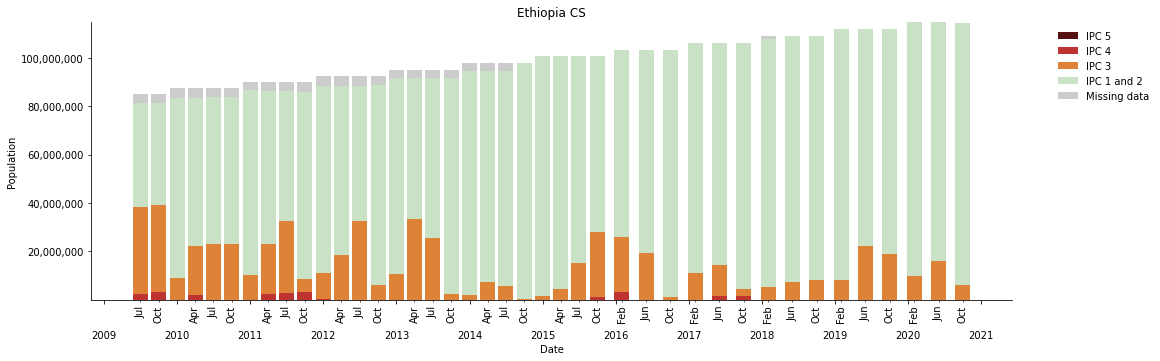

In [22]:
plot_ipclevels(df_fnat,adm1c="ADMIN0")

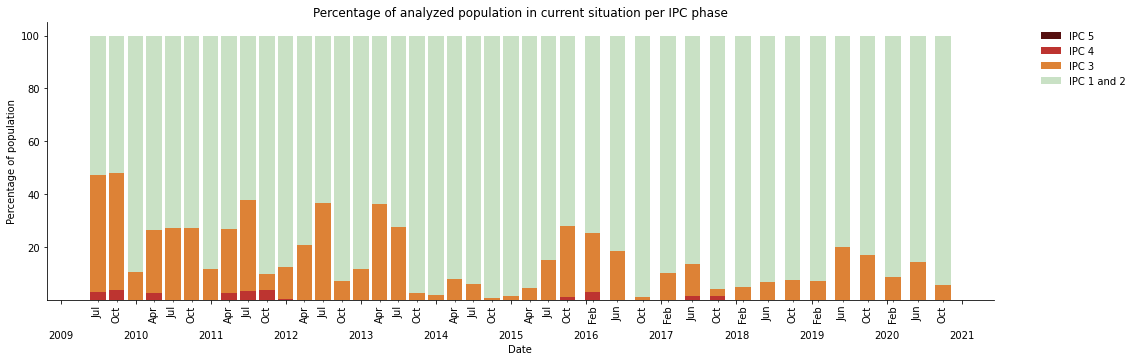

In [97]:
plot_ipclevels(df_fnat,adm1c="ADMIN0",status="CS",perc=True,title="Percentage of analyzed population in current situation per IPC phase")

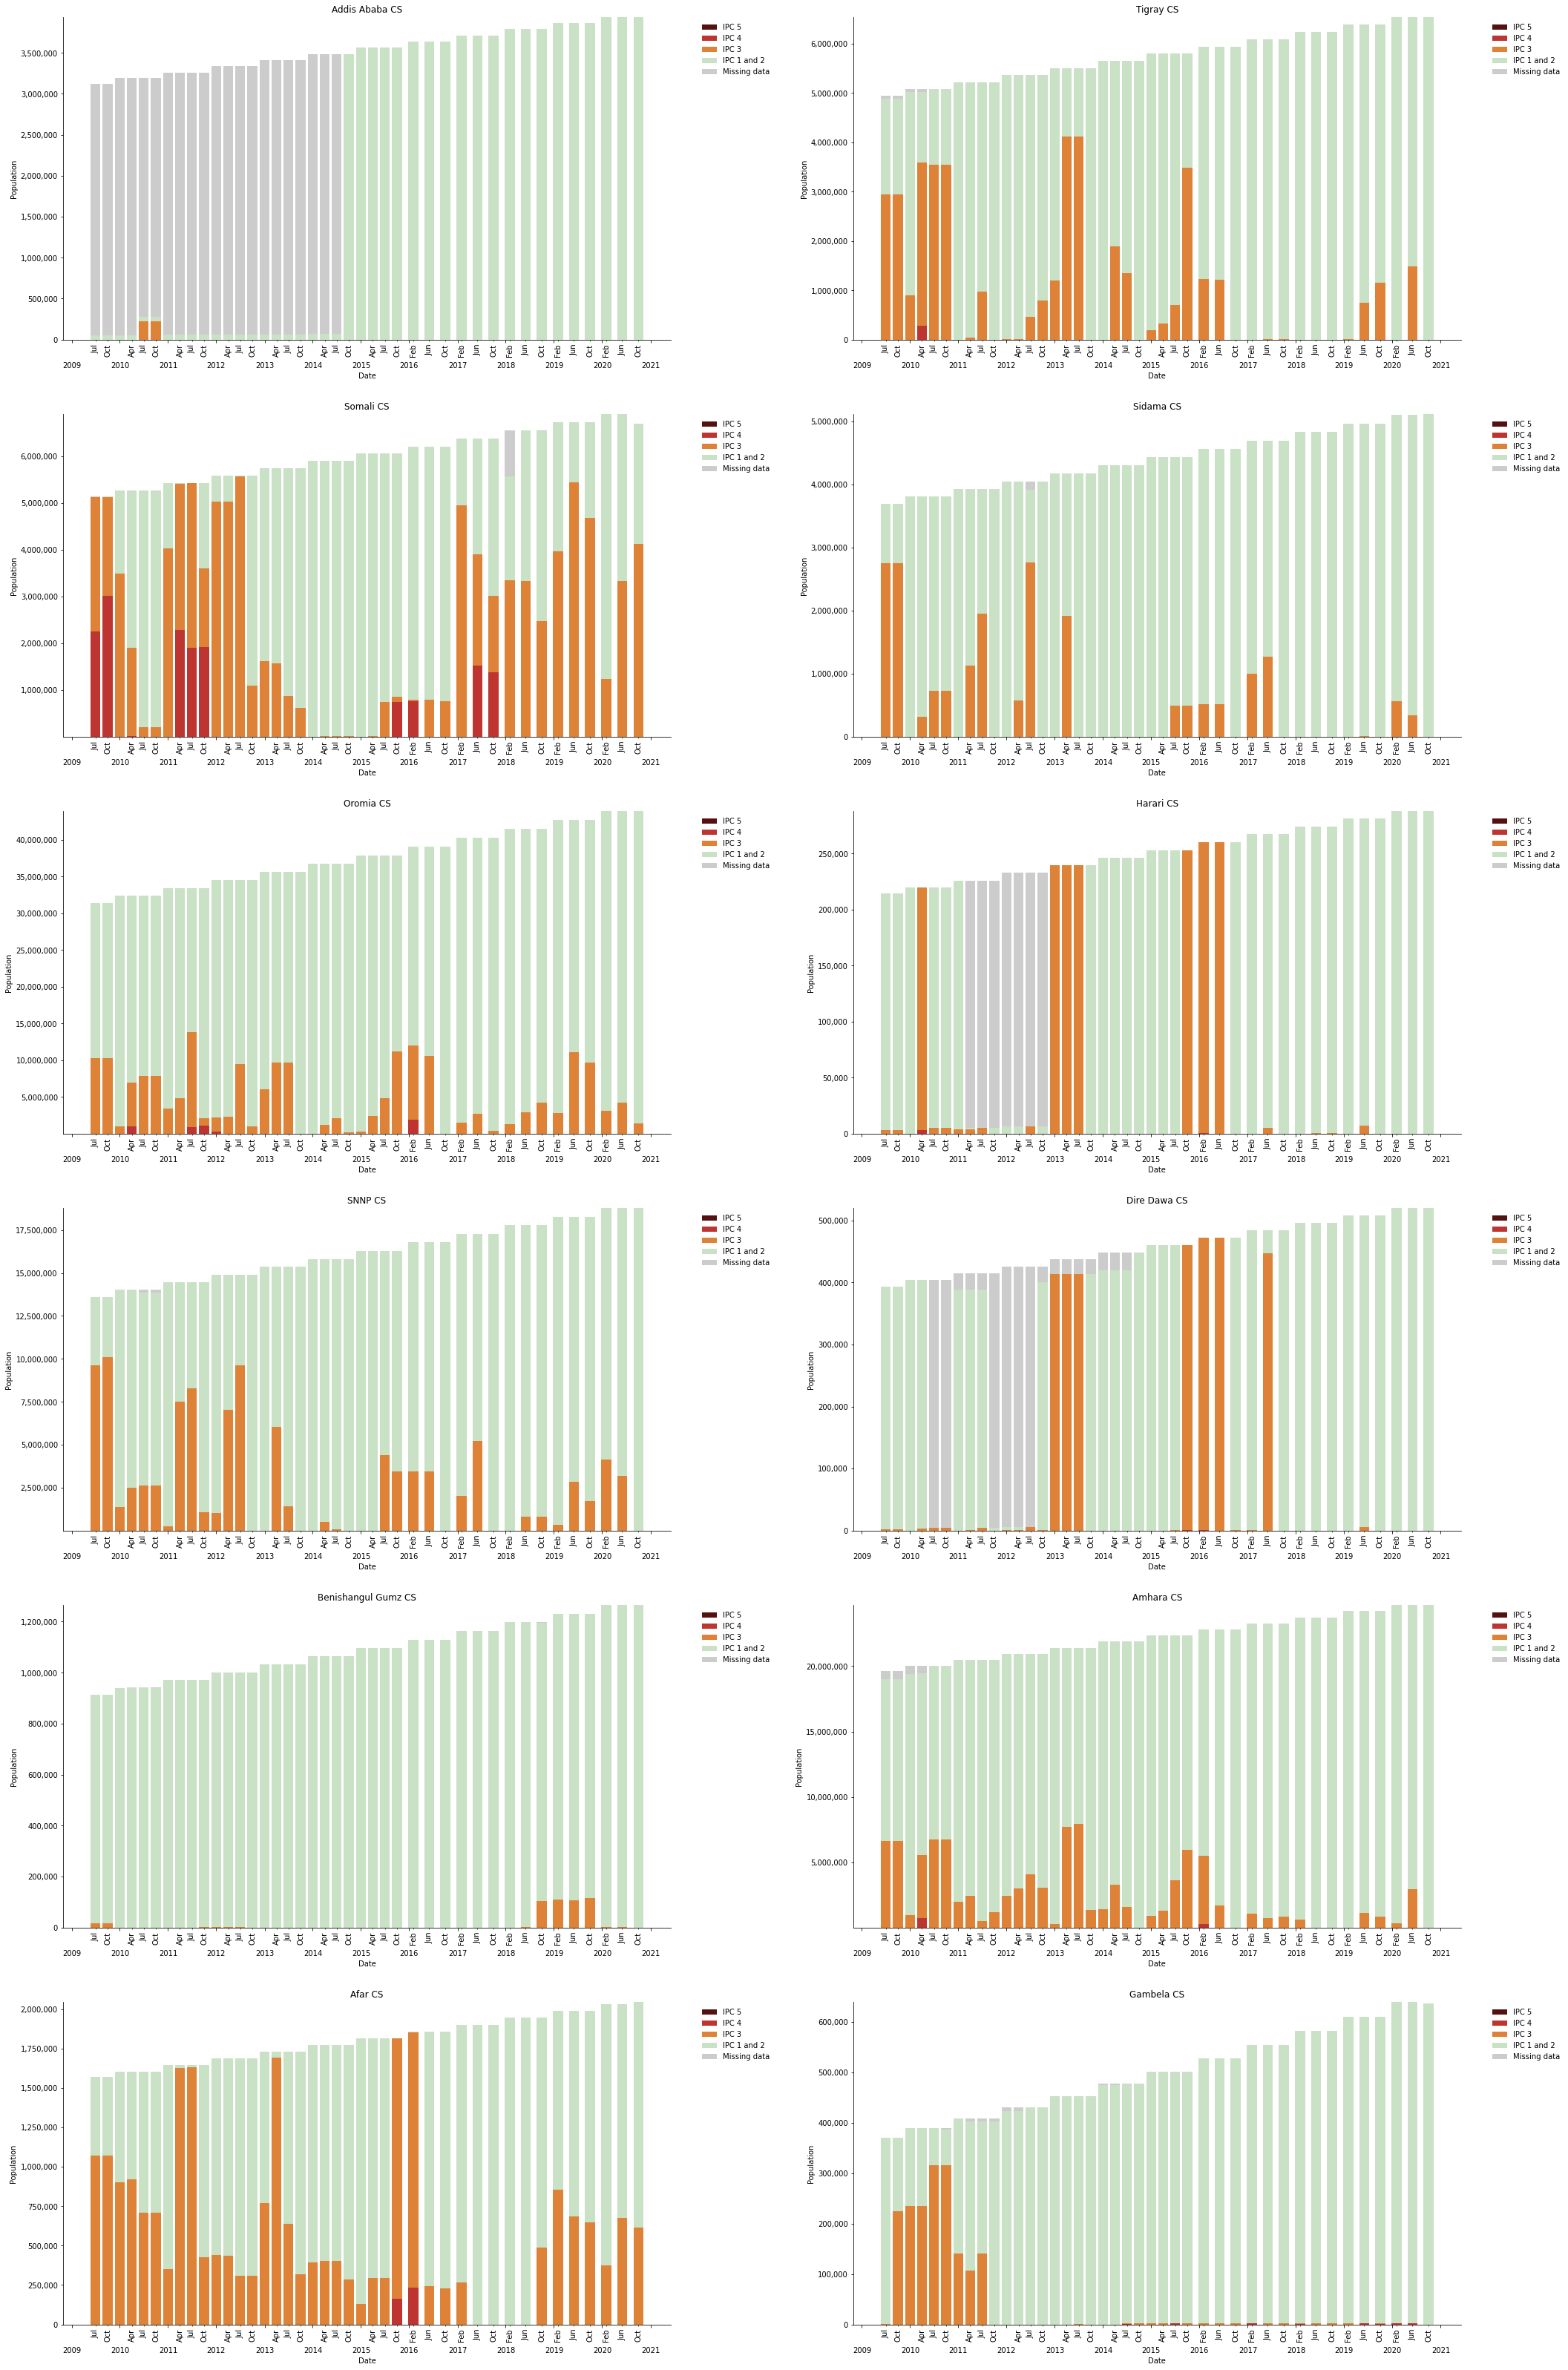

In [44]:
plot_ipclevels(df_fadm,figsize=(30,45))

#### Global IPC

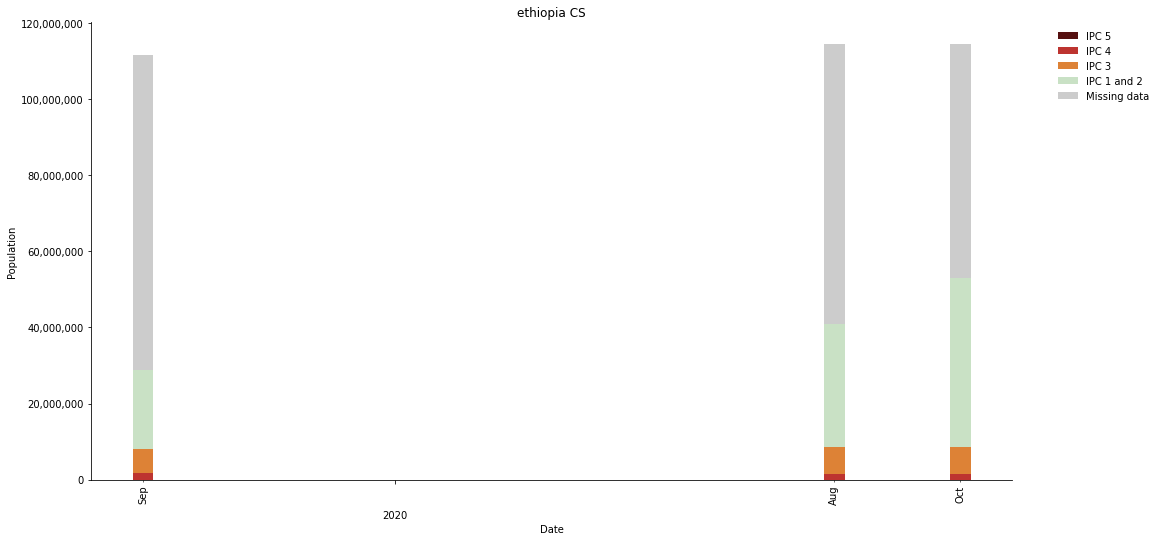

In [86]:
plot_ipclevels(df_gnat,adm1c="ADMIN0",pop_col="pop_total_CS",figsize=(30,45),width=10)

blub


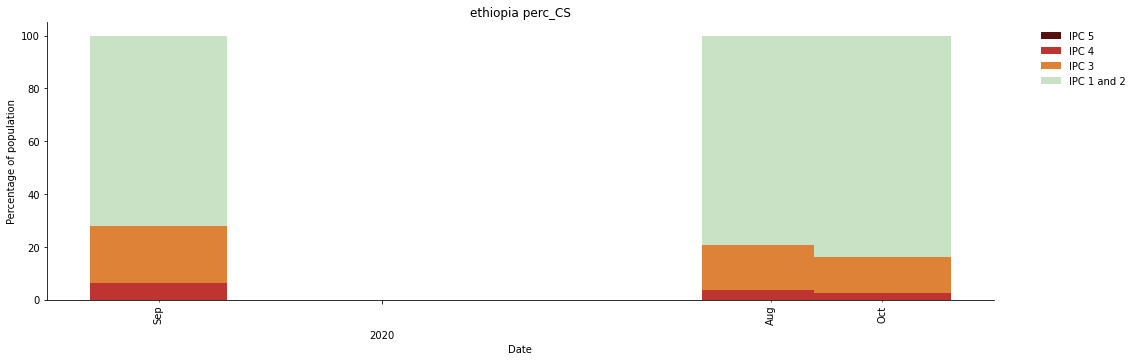

In [99]:
plot_ipclevels(df_gnat,adm1c="ADMIN0",status="CS",perc=True)

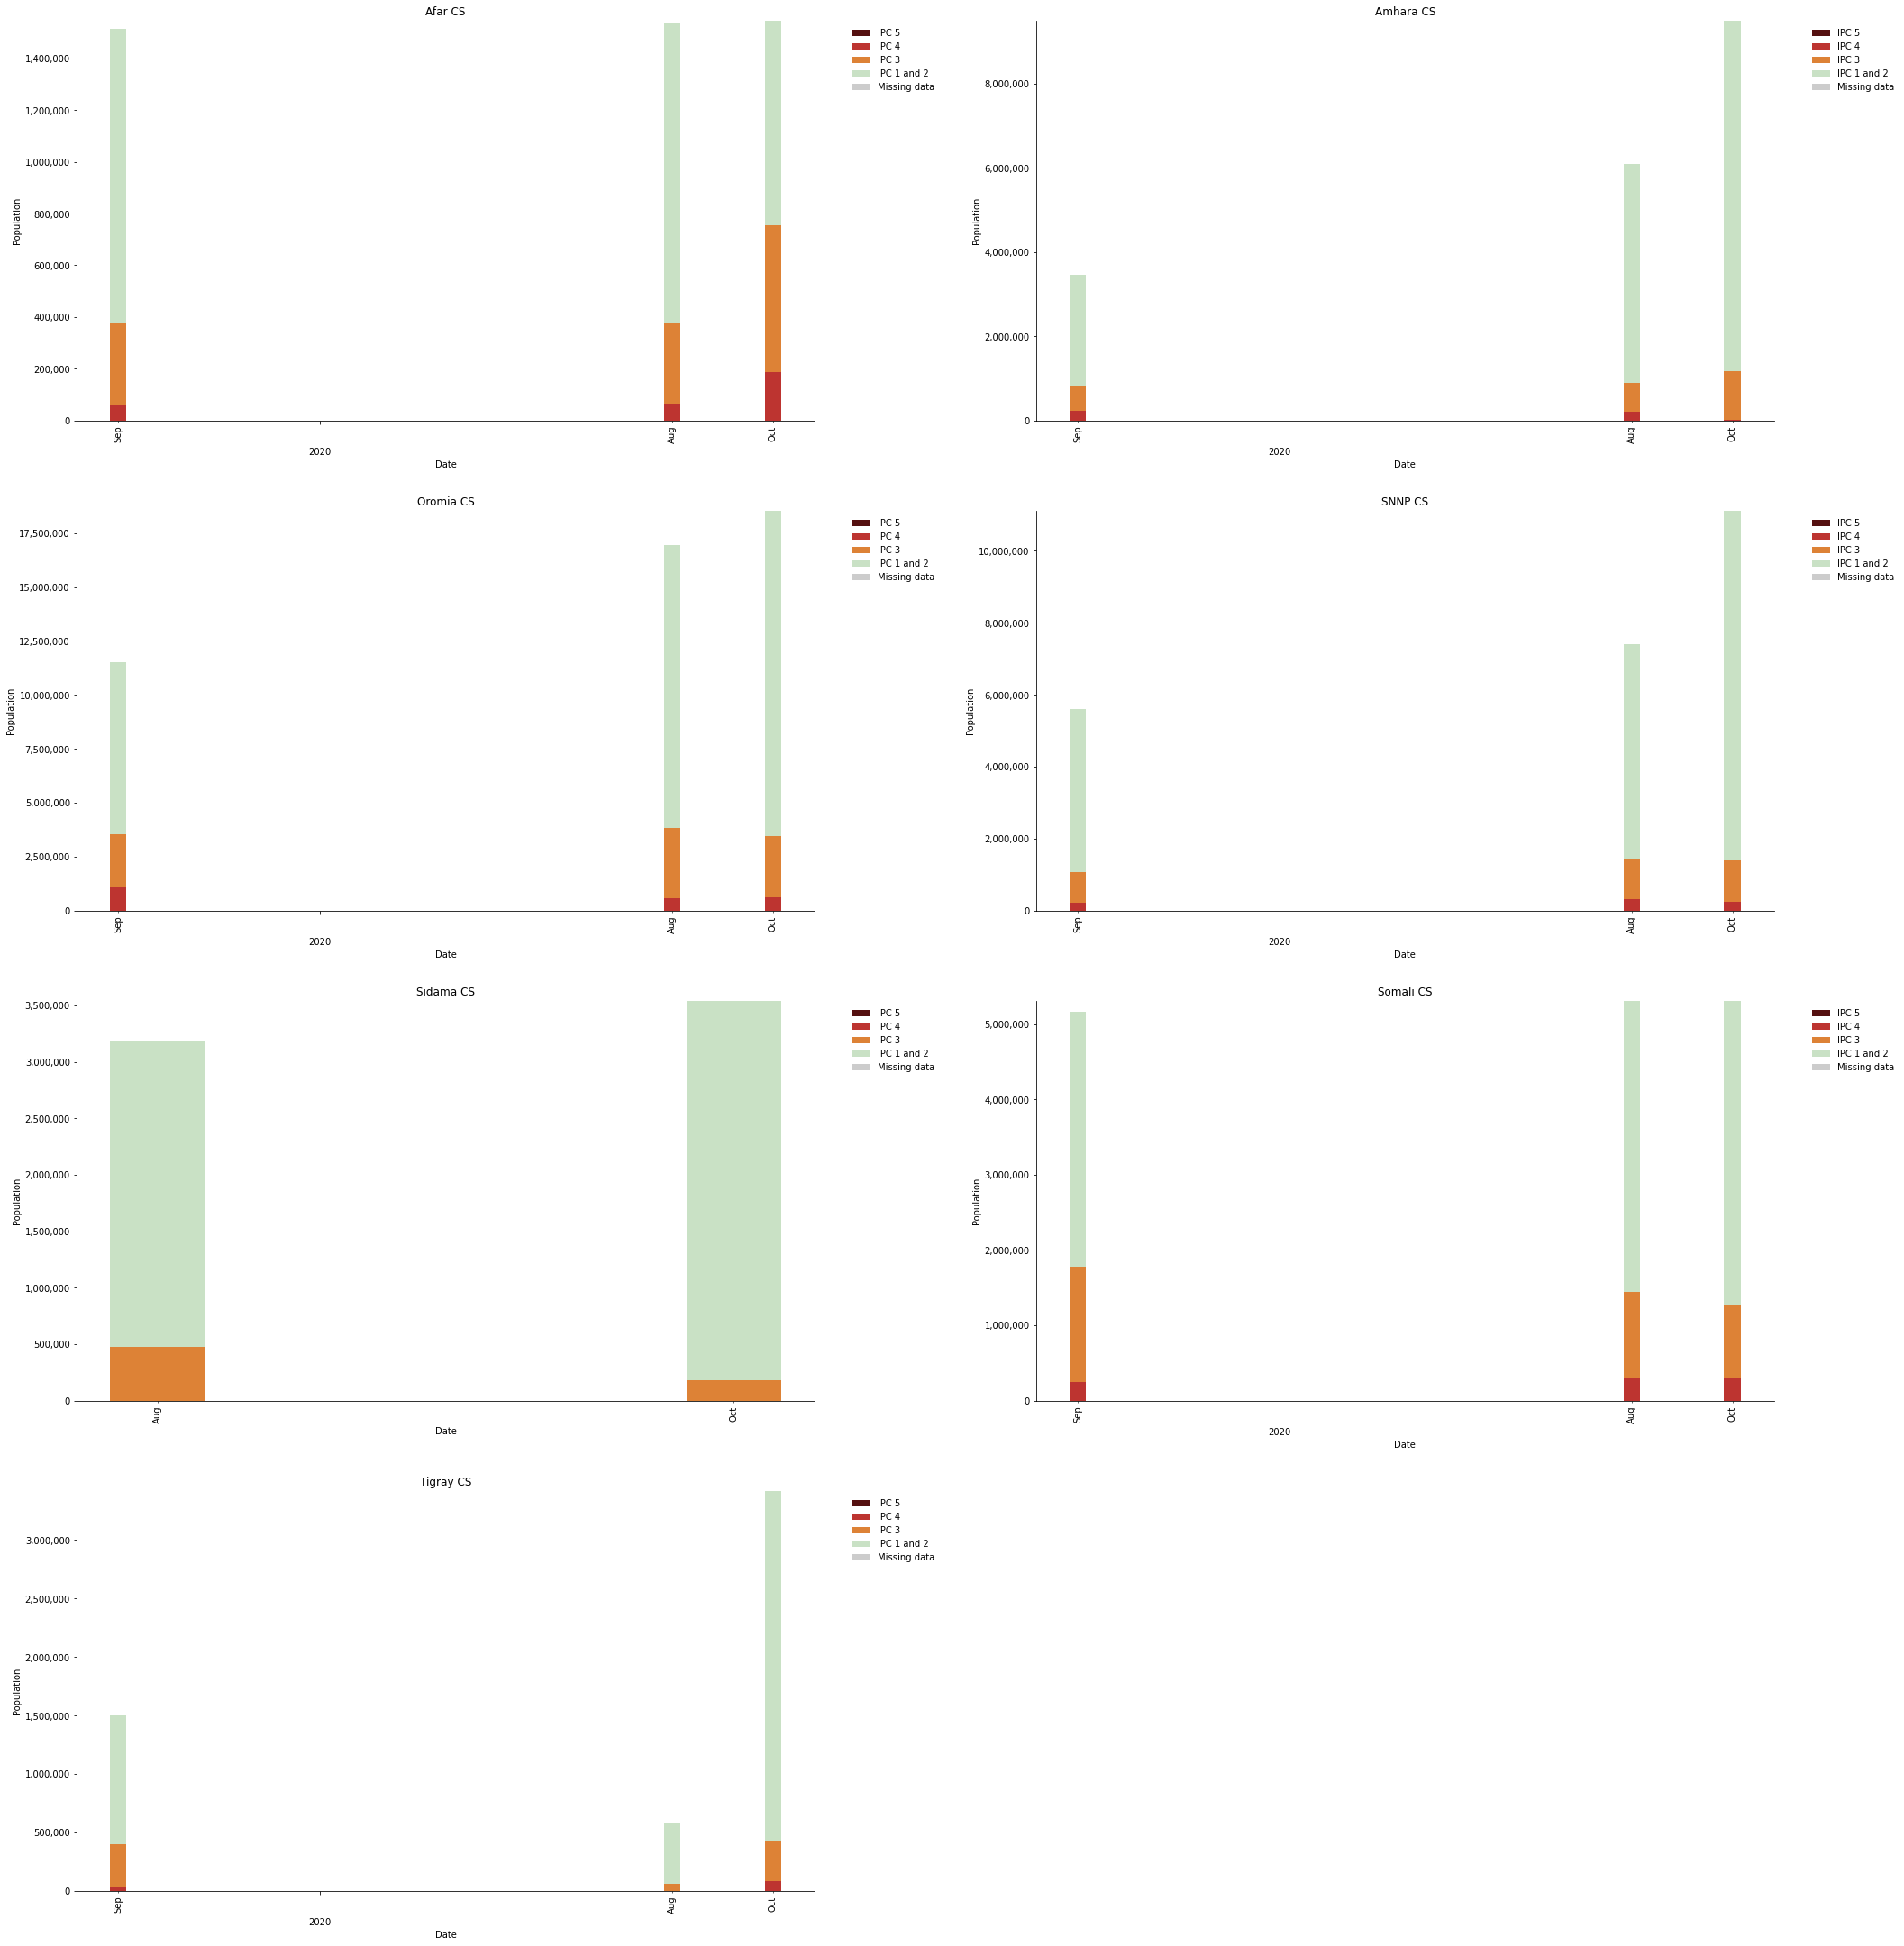

In [57]:
plot_ipclevels(df_gadm,adm1c=glob_adm1c,pop_col="pop_CS",figsize=(30,45),width=10)

In [18]:
def plot_aff_dates(df_d,col,shape_path="Data/ET_Admin1_OCHA_2019/eth_admbnda_adm1_csa_bofed_20190827.shp",title=None):
    """Plot a map with the values of col per admin1 for all dates included in df_d"""
    num_dates=len(df_d.date.unique())
    colp_num=2
    rows=num_dates // colp_num
    rows+=num_dates % colp_num
    position = range(1, num_dates + 1)

    gdf = gpd.read_file(shape_path)
    df_geo=gdf[["ADM1_EN","geometry"]].merge(df_d,on="ADM1_EN",how="left")
    
    colors = len(df_geo[col].unique())
    cmap = 'Blues'
    figsize = (16, 10)
    scheme = "natural_breaks"#'equalinterval'
    fig = plt.figure(1,figsize=(16,6*rows))
    
    for i,c in enumerate(df_d.date.unique()):
        ax = fig.add_subplot(rows,colp_num,position[i])
        df_date=df_geo[df_geo.date==c]
        if df_date[col].isnull().values.all():
            print(f"No not-NaN values for {c}")
        elif df_date[col].isnull().values.any():
            df_geo[df_geo.date==c].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme,missing_kwds={"color": "lightgrey", "edgecolor": "red",
   "hatch": "///",
    "label": "Missing values"})
        else:
            df_geo[df_geo.date==c].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme)
        gdf.boundary.plot(linewidth=0.2,ax=ax)

        ax.axis("off")
        
        plt.title(pd.DatetimeIndex([c])[0].to_period('M'))
        if not df_date[col].isnull().values.all():
            leg = ax.get_legend()

            for lbl in leg.get_texts():
                label_text = lbl.get_text()
                upper = label_text.split(",")[-1].rstrip(']')

                try:
                    new_text = f'{float(upper):,.2f}'
                except:
                    new_text=upper
                lbl.set_text(new_text)

    if title:
        fig.suptitle(title,fontsize=14)
    fig.tight_layout()#show()
    plt.show()

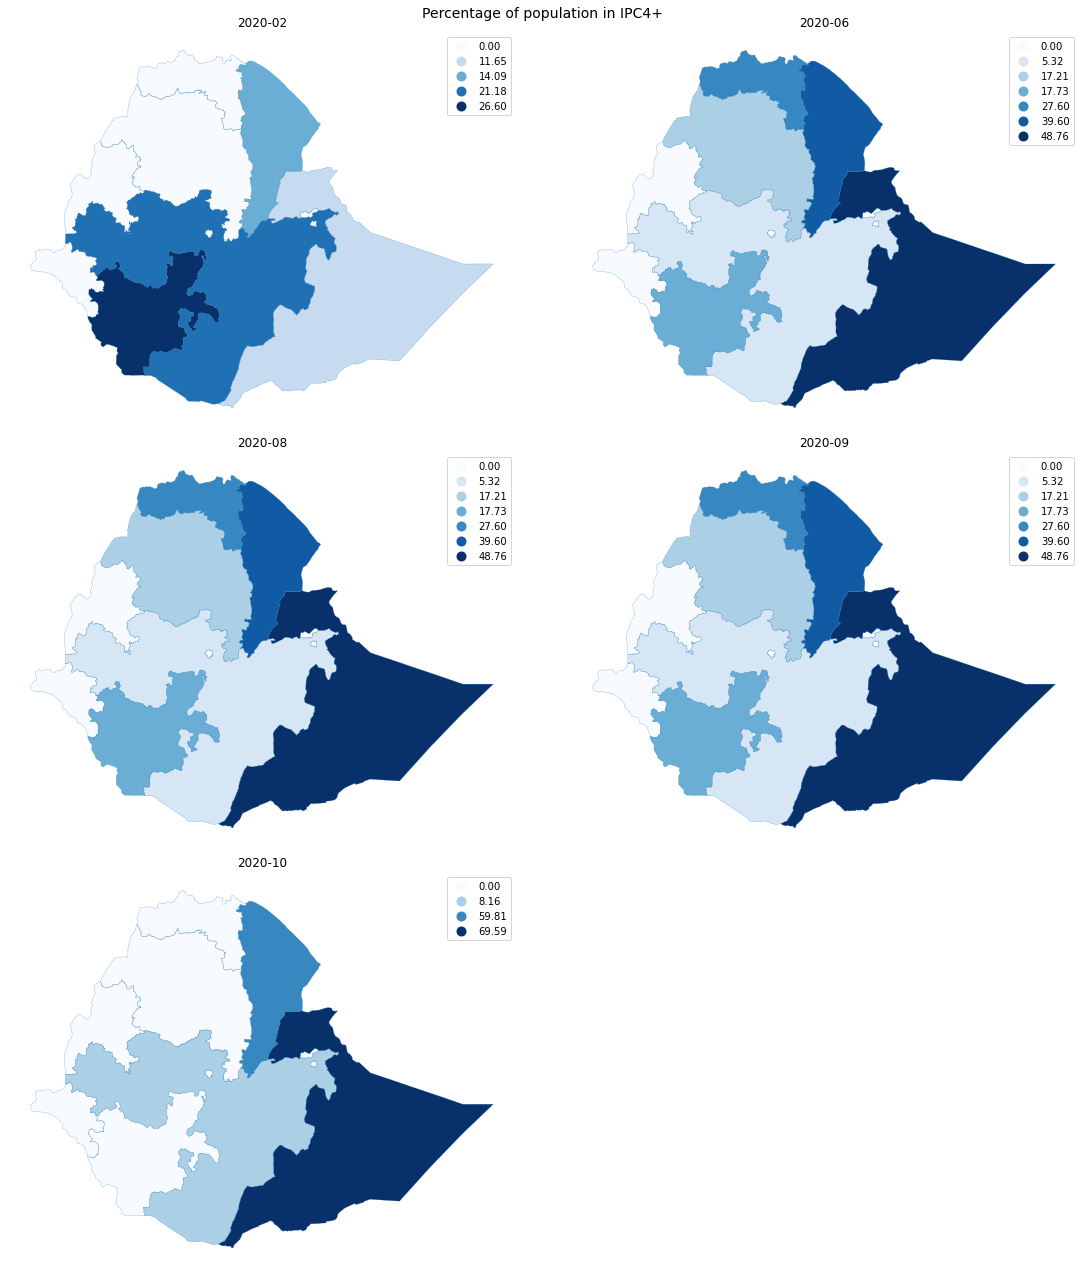

In [19]:
plot_aff_dates(df_fadm[df_fadm.date.dt.year==2020],"perc_CS_3p",title="Percentage of population in IPC4+")

### Compare Global IPC and FewsNet

In [73]:
df_fnat["Source"]="FewsNet"
df_gnat["Source"]="Global"

In [74]:
#manually select the closes dates of Global IPC and FewsNet..
list(df_gnat.date.dt.date.unique())

[datetime.date(2019, 9, 1),
 datetime.date(2020, 8, 1),
 datetime.date(2020, 10, 1)]

In [75]:
df_fnat.date.dt.date.unique()

array([datetime.date(2009, 7, 1), datetime.date(2009, 10, 1),
       datetime.date(2010, 1, 1), datetime.date(2010, 4, 1),
       datetime.date(2010, 7, 1), datetime.date(2010, 10, 1),
       datetime.date(2011, 1, 1), datetime.date(2011, 4, 1),
       datetime.date(2011, 7, 1), datetime.date(2011, 10, 1),
       datetime.date(2012, 1, 1), datetime.date(2012, 4, 1),
       datetime.date(2012, 7, 1), datetime.date(2012, 10, 1),
       datetime.date(2013, 1, 1), datetime.date(2013, 4, 1),
       datetime.date(2013, 7, 1), datetime.date(2013, 10, 1),
       datetime.date(2014, 1, 1), datetime.date(2014, 4, 1),
       datetime.date(2014, 7, 1), datetime.date(2014, 10, 1),
       datetime.date(2015, 1, 1), datetime.date(2015, 4, 1),
       datetime.date(2015, 7, 1), datetime.date(2015, 10, 1),
       datetime.date(2016, 2, 1), datetime.date(2016, 6, 1),
       datetime.date(2016, 10, 1), datetime.date(2017, 2, 1),
       datetime.date(2017, 6, 1), datetime.date(2017, 10, 1),
       datetime

In [76]:
df_gnatd=df_gnat[df_gnat.date.isin(["2019-9","2020-08"])]

In [77]:
df_fnatd=df_fnat[df_fnat.date.isin(["2019-10","2020-10"])]

In [78]:
df_fnatd[["period_ML1","period_ML2"]]

,period_ML1,period_ML2
37,Oct - Jan 2020,Feb - May 2020
42,Oct - Jan 2021,Feb - May 2021


In [92]:
df_fnatd["perc_ML1_2m"]

37    93.175128
42    91.594779
Name: perc_ML1_2m, dtype: float64

In [79]:
df_comb=pd.concat([df_gnatd,df_fnatd])

In [80]:
df_comb

,date,ADMIN0,CS_1,CS_2,CS_3,CS_4,CS_5,ML1_1,ML1_2,ML1_3,...,ML1_3p,ML1_4p,ML1_2m,ML2_3p,ML2_4p,ML2_2m,period_ML1,period_ML2,CS_12,perc_CS_12
0,2019-09-01,ethiopia,1.072652e+07,1.003359e+07,6.110425e+06,1.856568e+06,0.0,1.149247e+07,1.054484e+07,5.356000e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-08-01,ethiopia,1.951484e+07,1.300769e+07,7.064142e+06,1.441541e+06,0.0,2.191713e+07,1.244078e+07,5.856056e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,2019-10-01,Ethiopia,6.285802e+07,3.003877e+07,1.883879e+07,8.062720e+02,0.0,7.890035e+07,2.520994e+07,7.625042e+06,...,7.625848e+06,806.272034,1.041103e+08,2.020490e+07,938.026489,9.153164e+07,Oct - Jan 2020,Feb - May 2020,9.289679e+07,83.139245
42,2020-10-01,Ethiopia,8.186663e+07,2.646539e+07,6.164422e+06,0.000000e+00,0.0,7.936297e+07,2.550979e+07,9.623679e+06,...,9.623679e+06,0.000000,1.048728e+08,2.581378e+07,0.000000,8.868266e+07,Oct - Jan 2021,Feb - May 2021,1.083320e+08,94.616058


In [99]:
df_combm=df_comb.melt(id_vars=["Source","date"],value_name="percentage",value_vars=['perc_CS_2m','perc_CS_3',"perc_CS_4","perc_CS_5"])

In [100]:
df_combm["year"]=df_combm.date.dt.year

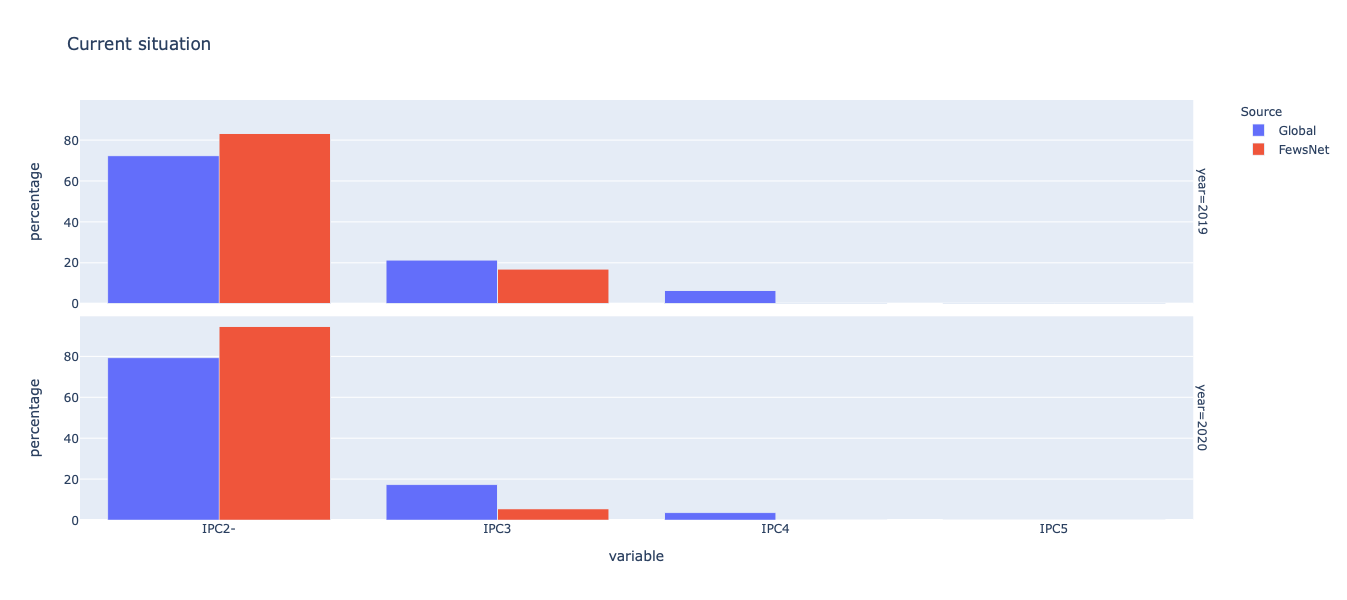

In [101]:
fig=px.bar(df_combm,x="variable",y="percentage",color="Source",facet_row="year",barmode="group",height=600,width=800,title="Current situation") #,facet_row="year"
fig.update_xaxes(ticktext=["IPC2-","IPC3","IPC4","IPC5"],tickvals=["perc_CS_2m","perc_CS_3","perc_CS_4","perc_CS_5"])

fig.show()

In [102]:
df_combm=df_comb.melt(id_vars=["Source","date"],value_name="percentage",value_vars=['perc_ML1_2m','perc_ML1_3',"perc_ML1_4","perc_ML1_5"])

In [103]:
df_combm["year"]=df_combm.date.dt.year

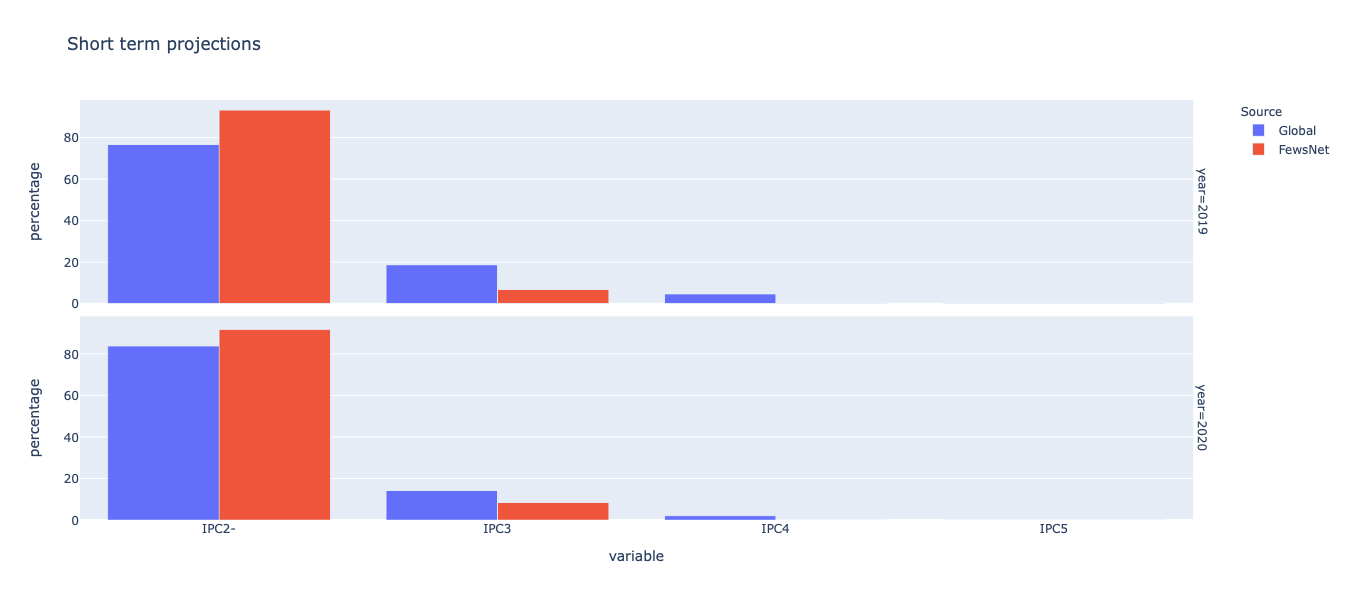

In [104]:
fig=px.bar(df_combm,x="variable",y="percentage",color="Source",facet_row="year",barmode="group",height=600,width=800,title="Short term projections") #,facet_row="year"
fig.update_xaxes(ticktext=["IPC2-","IPC3","IPC4","IPC5"],tickvals=["perc_ML1_2m","perc_ML1_3","perc_ML1_4","perc_ML1_5"])
fig.show()

In [105]:
df_combm=df_comb.melt(id_vars=["Source","date"],value_name="percentage",value_vars=['perc_ML2_2m','perc_ML2_3',"perc_ML2_4","perc_ML2_5"])

In [106]:
df_combm["year"]=df_combm.date.dt.year

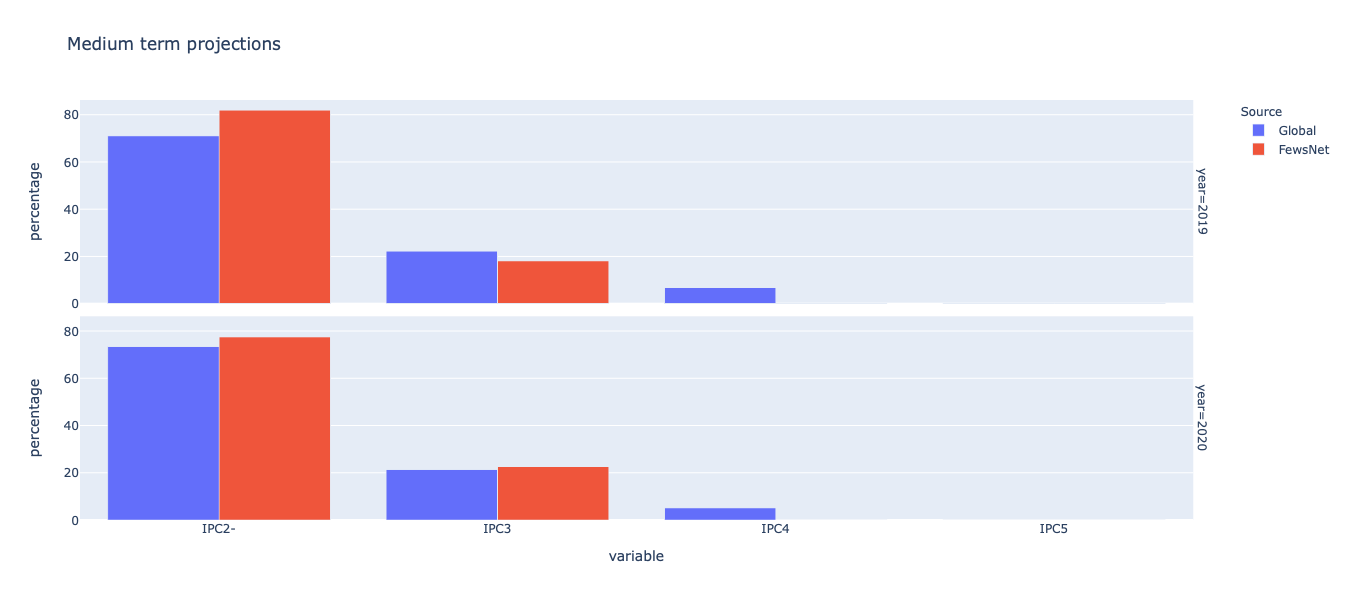

In [107]:
fig=px.bar(df_combm,x="variable",y="percentage",color="Source",facet_row="year",barmode="group",height=600,width=800,title="Medium term projections") #,facet_row="year"
fig.update_xaxes(ticktext=["IPC2-","IPC3","IPC4","IPC5"],tickvals=["perc_ML2_2m","perc_ML2_3","perc_ML2_4","perc_ML2_5"])
fig.show()

In [32]:
g_adm1=df_gadm.ADMIN1.unique()

In [33]:
df_fadms=df_fadm[df_fadm.date.isin(["2019-10","2020-06"])]

In [34]:
df_fadms=df_fadms.rename(columns={"ADM1_EN":"ADMIN1"})
df_fadms=df_fadms[df_fadms.ADMIN1.isin(g_adm1)]

df_fadms["Source"]="FewsNet"
df_gadm["Source"]="Global"

In [35]:
df_adm1c=pd.concat([df_gadm,df_fadms])


In [36]:
df_adm1cm=df_adm1c.melt(id_vars=["Source","date","ADMIN1"],value_name="percentage",value_vars=['perc_CS_2m','perc_CS_3',"perc_CS_4","perc_CS_5"])
df_adm1cm["year"]=df_adm1cm.date.dt.year

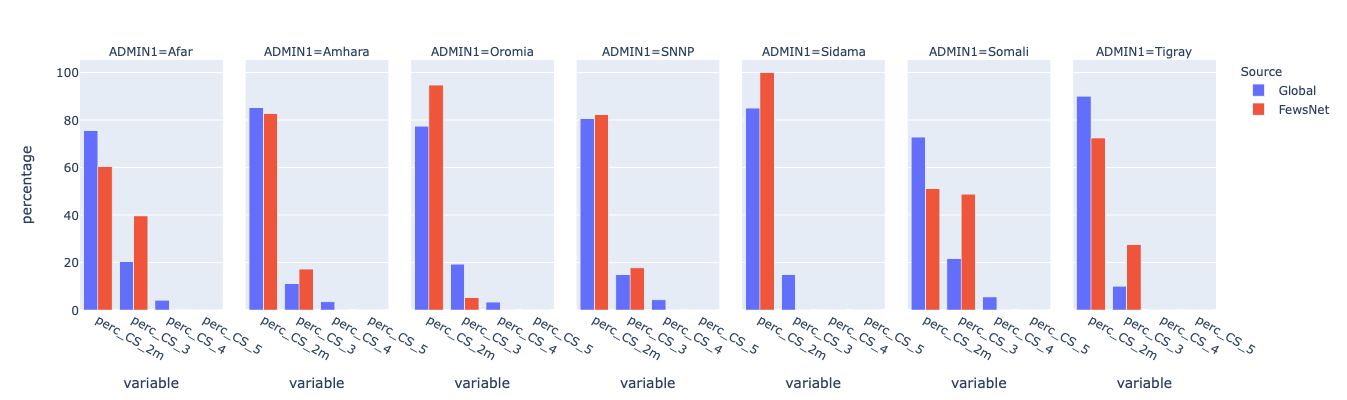

In [37]:
#Sidama is a new admin1 region in Ethiopia that wasn't included in the 06-2020 FewsNet analysis
px.bar(df_adm1cm[df_adm1cm.year==2020],x="variable",y="percentage",color="Source",facet_col="ADMIN1",barmode="group",height=400,width=1300) #,facet_row="year"

### Actual value (CS) versus forecasted values (ML1 and ML2)
Only being done for FewsNet.  
For global IPC we have two timestamps of data till today, where none of the dates overlap. Thus, we cannot do an analysis on accuracy

In [38]:
#set the forecasted ML1 and ML2 values for the connected date
#now assumed ML1 is always forecasted for the next date in the df. This can be too simplified, in 'old stuff' is a start to do this more correctly
#(optimally the dates for which forecasts were produced would already be included in the df from the start)
shift_cols_ML1=["date"] + [f"ML1_{i}" for i in range(1,6)]+[f"perc_ML1_{i}" for i in range(1,6)]+["ML1_3p","perc_ML1_3p"]
shift_cols_ML2=["date"] + [f"ML2_{i}" for i in range(1,6)]+[f"perc_ML2_{i}" for i in range(1,6)]+["ML2_3p","perc_ML2_3p"]
df_fnat[[f"{c}_next" for c in shift_cols_ML1]]=df_fnat[shift_cols_ML1].shift(1)
df_fnat[[f"{c}_next2" for c in shift_cols_ML2]]=df_fnat[shift_cols_ML2].shift(2)
df_fadm[[f"{c}_next" for c in shift_cols_ML1]]=df_fadm.groupby("ADM1_EN")[shift_cols_ML1].shift(1)
df_fadm[[f"{c}_next2" for c in shift_cols_ML2]]=df_fadm.groupby("ADM1_EN")[shift_cols_ML2].shift(2)

#set to nan if difference in dates is larger than 130/250, i.e. forecast was not for next date in df
#dont include "date" in shift_cols_ML1
for i in shift_cols_ML1[1:]:
    df_fnat[i] = df_fnat[i].where((df_fnat.date - df_fnat.date_next) <= timedelta(130), np.nan)
    df_fadm[i] = df_fadm[i].where((df_fadm.date - df_fadm.date_next) <= timedelta(130), np.nan)
for i in shift_cols_ML2[1:]:
    df_fnat[i] = df_fnat[i].where((df_fnat.date - df_fnat.date_next2) <= timedelta(250), np.nan)
    df_fadm[i] = df_fadm[i].where((df_fadm.date - df_fadm.date_next2) <= timedelta(250), np.nan)

In [39]:
df_fadmt=pd.read_csv(f"Data/FewsNetProcessed/{country}_fewsnet_admin2{suffix}.csv",index_col=0)

In [40]:
#add forecasted values to date they were forecasted for
for a in df_fadmt.ADM1_EN.unique():
    for b in df_fadmt.ADM2_EN.unique():
        df_fadmt.loc[(df_fadmt.ADM1_EN==a) & (df_fadmt.ADM2_EN==b),f"ML1_next"]=df_fadmt.loc[(df_fadmt.ADM1_EN==a) & (df_fadmt.ADM2_EN==b),"ML1"].shift(1).to_numpy()
        df_fadmt.loc[(df_fadmt.ADM1_EN==a) & (df_fadmt.ADM2_EN==b),f"ML2_next2"]=df_fadmt.loc[(df_fadmt.ADM1_EN==a) & (df_fadmt.ADM2_EN==b),"ML2"].shift(2).to_numpy()
        df_fadmt.loc[(df_fadmt.ADM1_EN==a) & (df_fadmt.ADM2_EN==b),f"date_next"]=df_fadmt.loc[(df_fadmt.ADM1_EN==a) & (df_fadmt.ADM2_EN==b),"date"].shift(1).to_numpy()
        df_fadmt.loc[(df_fadmt.ADM1_EN==a) & (df_fadmt.ADM2_EN==b),f"date_next2"]=df_fadmt.loc[(df_fadmt.ADM1_EN==a) & (df_fadmt.ADM2_EN==b),"date"].shift(2).to_numpy()

In [41]:
df_fadmt["CS_3p"]=np.where(df_fadmt.CS>=3,1,0)
df_fadmt["ML1_next_3p"]=np.where(df_fadmt.ML1_next>=3,1,0)
df_fadmt["ML2_next2_3p"]=np.where(df_fadmt.ML2_next2>=3,1,0)

In [42]:
df_fadmts=df_fadmt.dropna()

In [43]:
print("Accuracy of ML1 forecasts:",accuracy_score(df_fadmts.CS,df_fadmts.ML1_next))

Accuracy of ML1 forecasts: 0.7804942864735583


In [44]:
print("Accuracy of ML2 forecasts:",accuracy_score(df_fadmts.CS,df_fadmts.ML2_next2))

Accuracy of ML2 forecasts: 0.7222960403933032


In [45]:
print("Accuracy of ML1 forecasts for IPC3+:",accuracy_score(df_fadmts.CS_3p,df_fadmts.ML1_next_3p))

Accuracy of ML1 forecasts for IPC3+: 0.8748339091150678


In [46]:
print("Accuracy of ML2 forecasts for IPC3+:",accuracy_score(df_fadmts.CS_3p,df_fadmts.ML2_next2_3p))

Accuracy of ML2 forecasts for IPC3+: 0.8410842412968377


In [47]:
df_fadmt["CSminML1"]=df_fadmt["CS"]-df_fadmt["ML1_next"]

In [48]:
#can be seen that about equally divided whether ML1 is over or underpredicting CS
df_fadmt.value_counts("CSminML1").sort_index()

CSminML1
-3.0       1
-2.0      18
-1.0     407
 0.0    3030
 1.0     386
 2.0      15
dtype: int64

In [49]:
df_fadmt["CSminML2"]=df_fadmt["CS"]-df_fadmt["ML2_next2"]

In [50]:
df_fadmt.value_counts("CSminML2").sort_index()

CSminML2
-3.0       2
-2.0      46
-1.0     485
 0.0    2718
 1.0     469
 2.0      43
dtype: int64

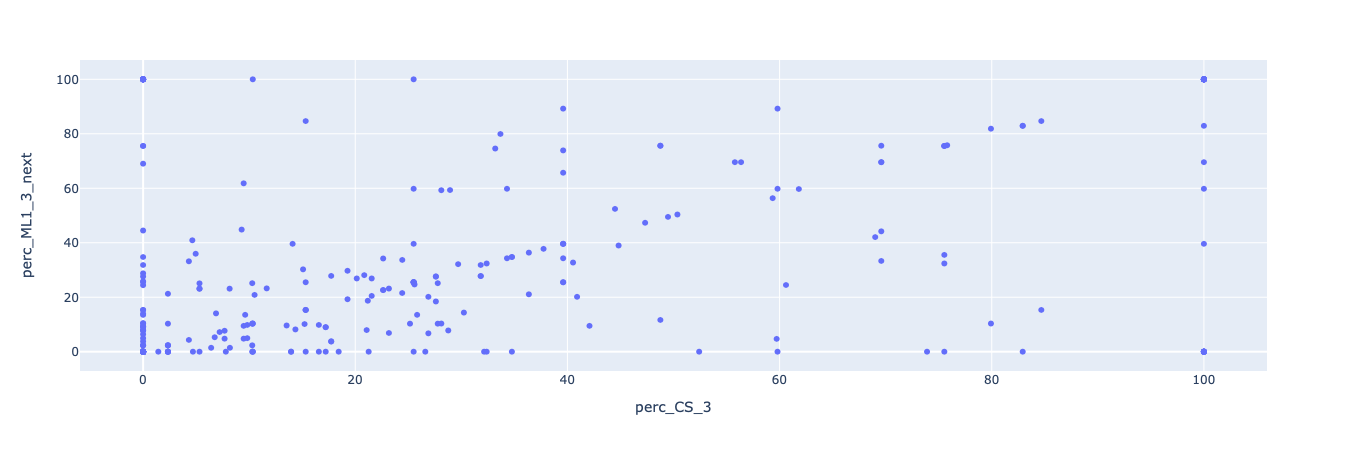

In [51]:
px.scatter(df_fadm,x="perc_CS_3",y="perc_ML1_3_next",width=500,height=450)

In [52]:
def plot_preds(df,adm1c="ADM1_EN"):
    color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
    
    width = 75
    count = 1
    fig, ax = plt.subplots(figsize=(20,30))
  
    for region in df[adm1c].unique():
        ax = plt.subplot(6,2,count)
        data = df.loc[df[adm1c]==region]
        plt.plot(data['date'], data['perc_CS_3p'], label='CS',
                         alpha=0.75, color='#E6B655', linestyle='-', linewidth=4)
        plt.plot(data['date'], data['perc_ML1_3p_next'], color='#388c50',
                         label='ML1', linestyle=':', linewidth=2)
        plt.plot(data['date'], data['perc_ML2_3p_next2'], color='#c24e2d',
                         label='ML2', linestyle='-.', linewidth=2)
        plt.title(f"{region} IPC 3+")
        ax.legend(bbox_to_anchor=(1.04, 1),frameon=False,title="Legend")

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlabel("Date")
        ax.set_ylabel("Percentage of population")
        ax.set_xticks(data.date.values,minor=True)
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        count+=1
    fig.tight_layout(pad=3.0)

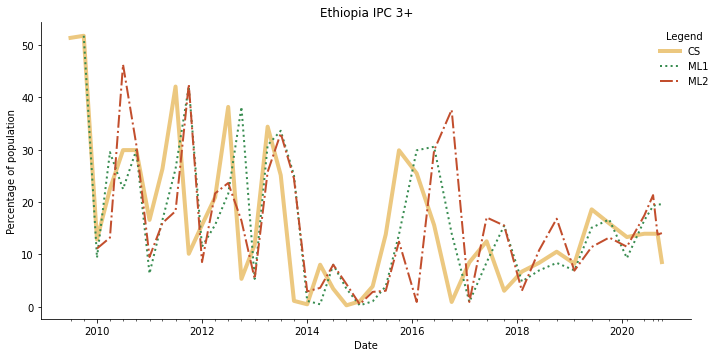

In [53]:
plot_preds(df_fnat)

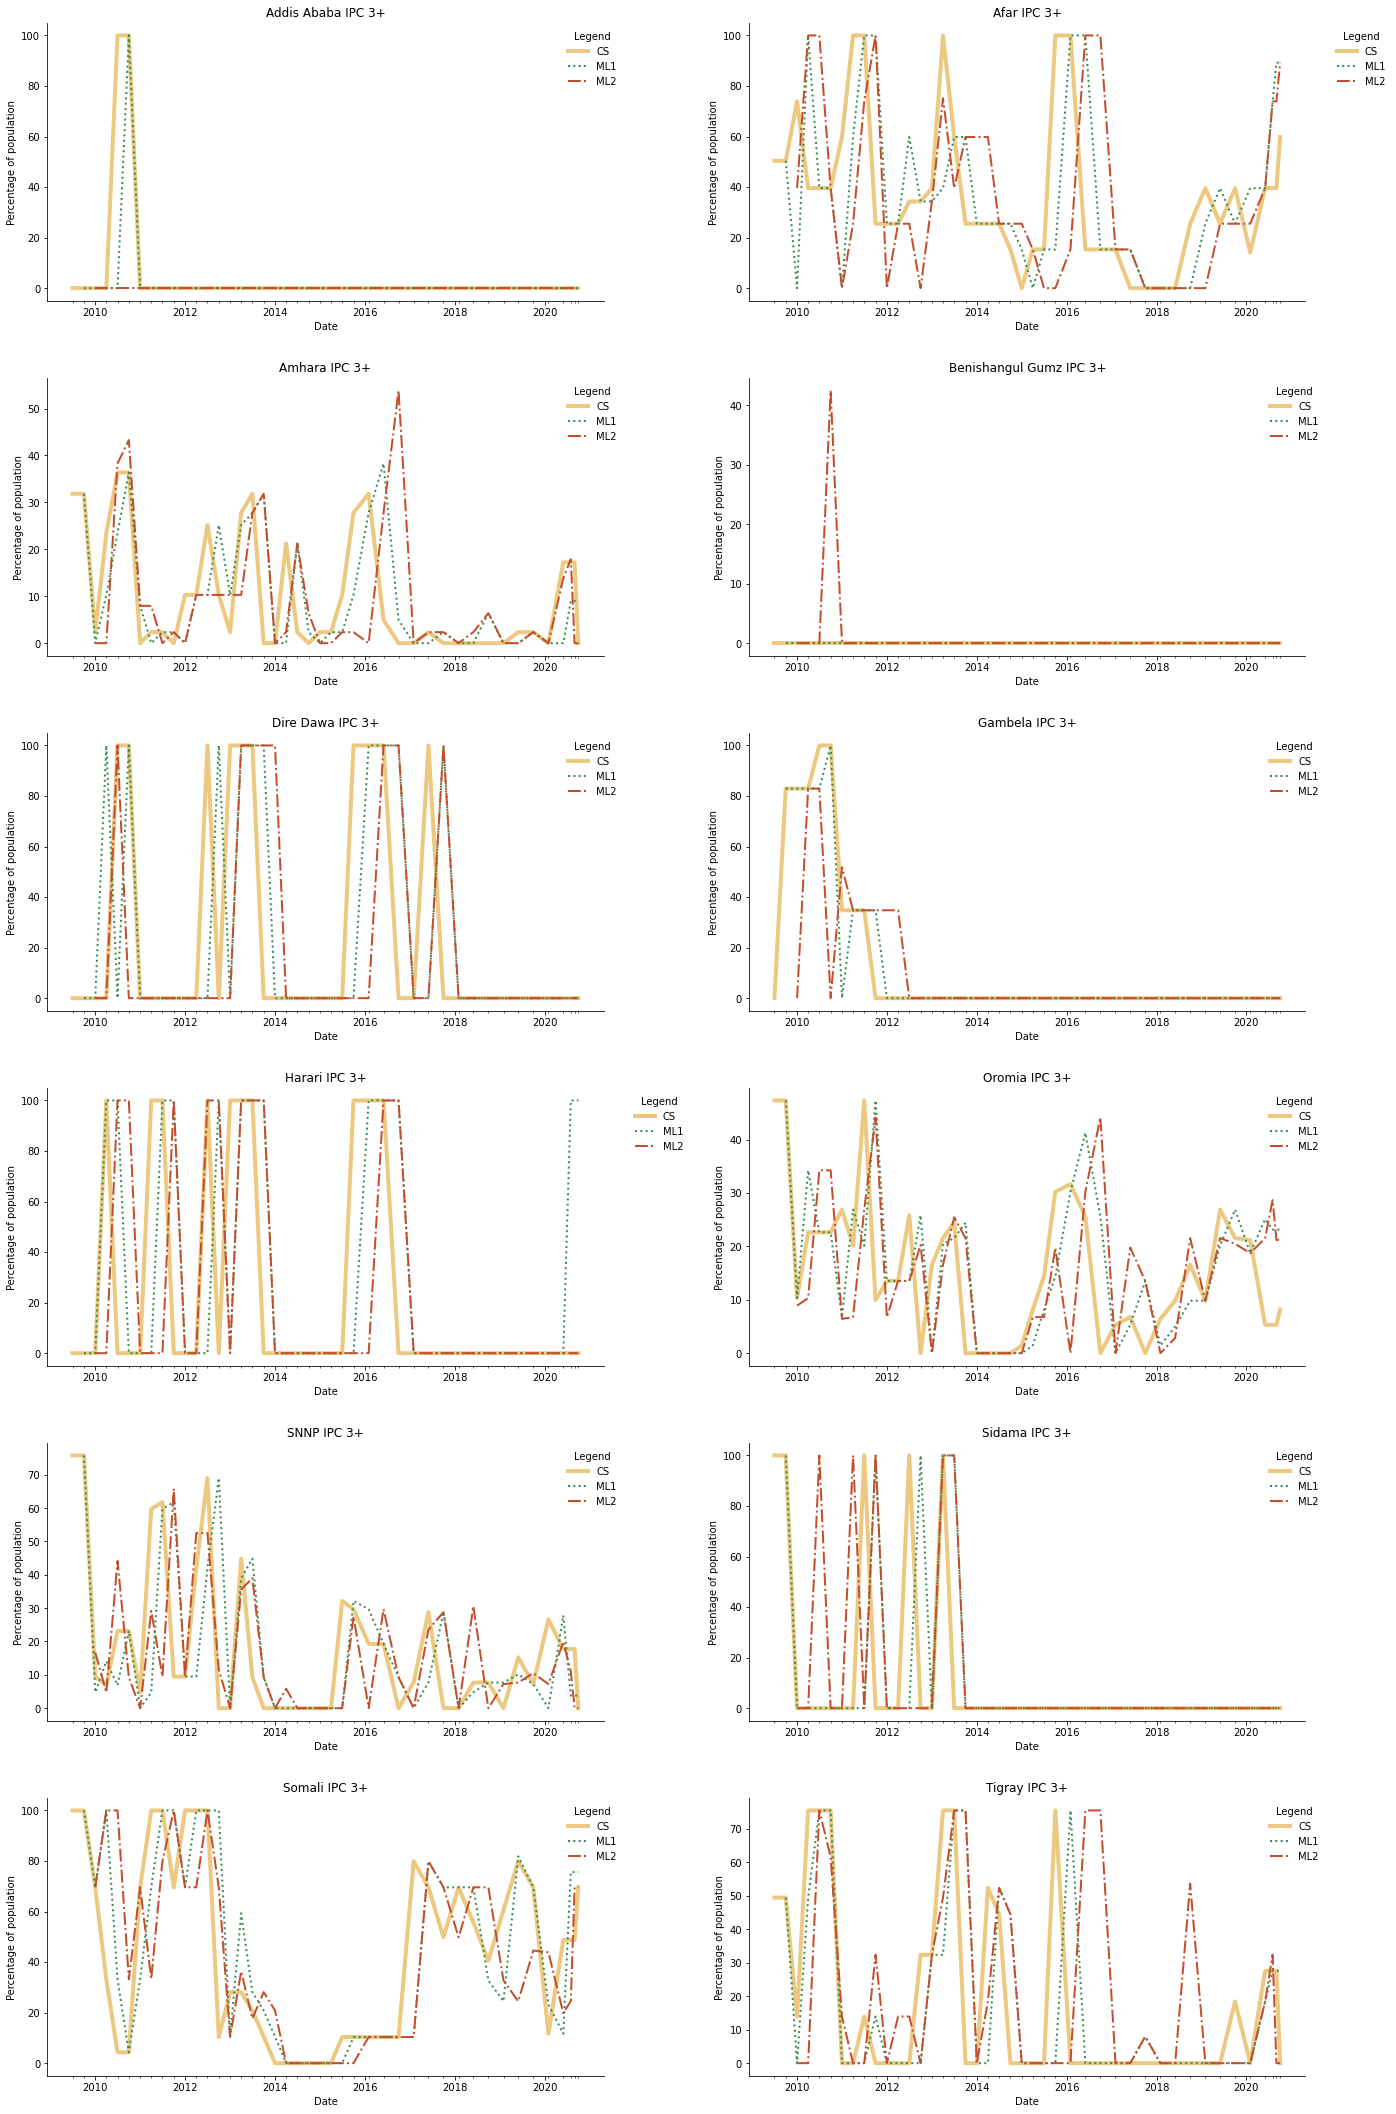

In [54]:
plot_preds(df_fadm)

In [55]:
def plot_preds_nodelay(df,adm1c="ADM1_EN"):
    color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
    
    width = 75
    count = 1
    fig, ax = plt.subplots(figsize=(20,30))
  
    for region in df[adm1c].unique():
        ax = plt.subplot(6,2,count)
        data = df.loc[df[adm1c]==region]
        plt.plot(data['date'], data['perc_CS_3p'], label='CS',
                         alpha=0.75, color='#E6B655', linestyle='-', linewidth=4)
        plt.plot(data['date'], data['perc_ML1_3p'], color='#388c50',
                         label='ML1', linestyle=':', linewidth=2)
        plt.plot(data['date'], data['perc_ML2_3p'], color='#c24e2d',
                         label='ML2', linestyle='-.', linewidth=2)
        plt.title(f"NO DELAY! {region} IPC 3+")
        ax.legend(bbox_to_anchor=(1.04, 1),frameon=False,title="Legend")

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        ax.set_xticks(data.date.values,minor=True)
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        count+=1
    fig.tight_layout(pad=3.0)
    

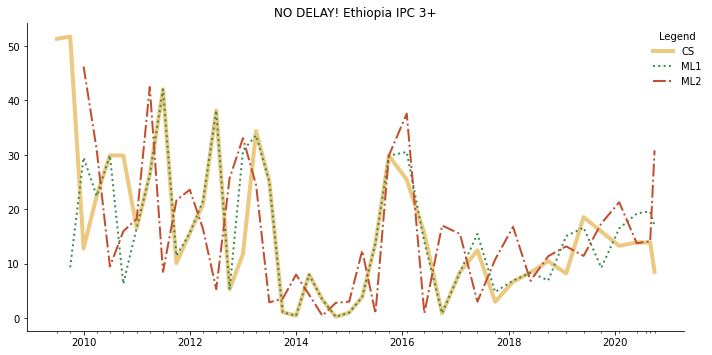

In [56]:
plot_preds_nodelay(df_fnat)

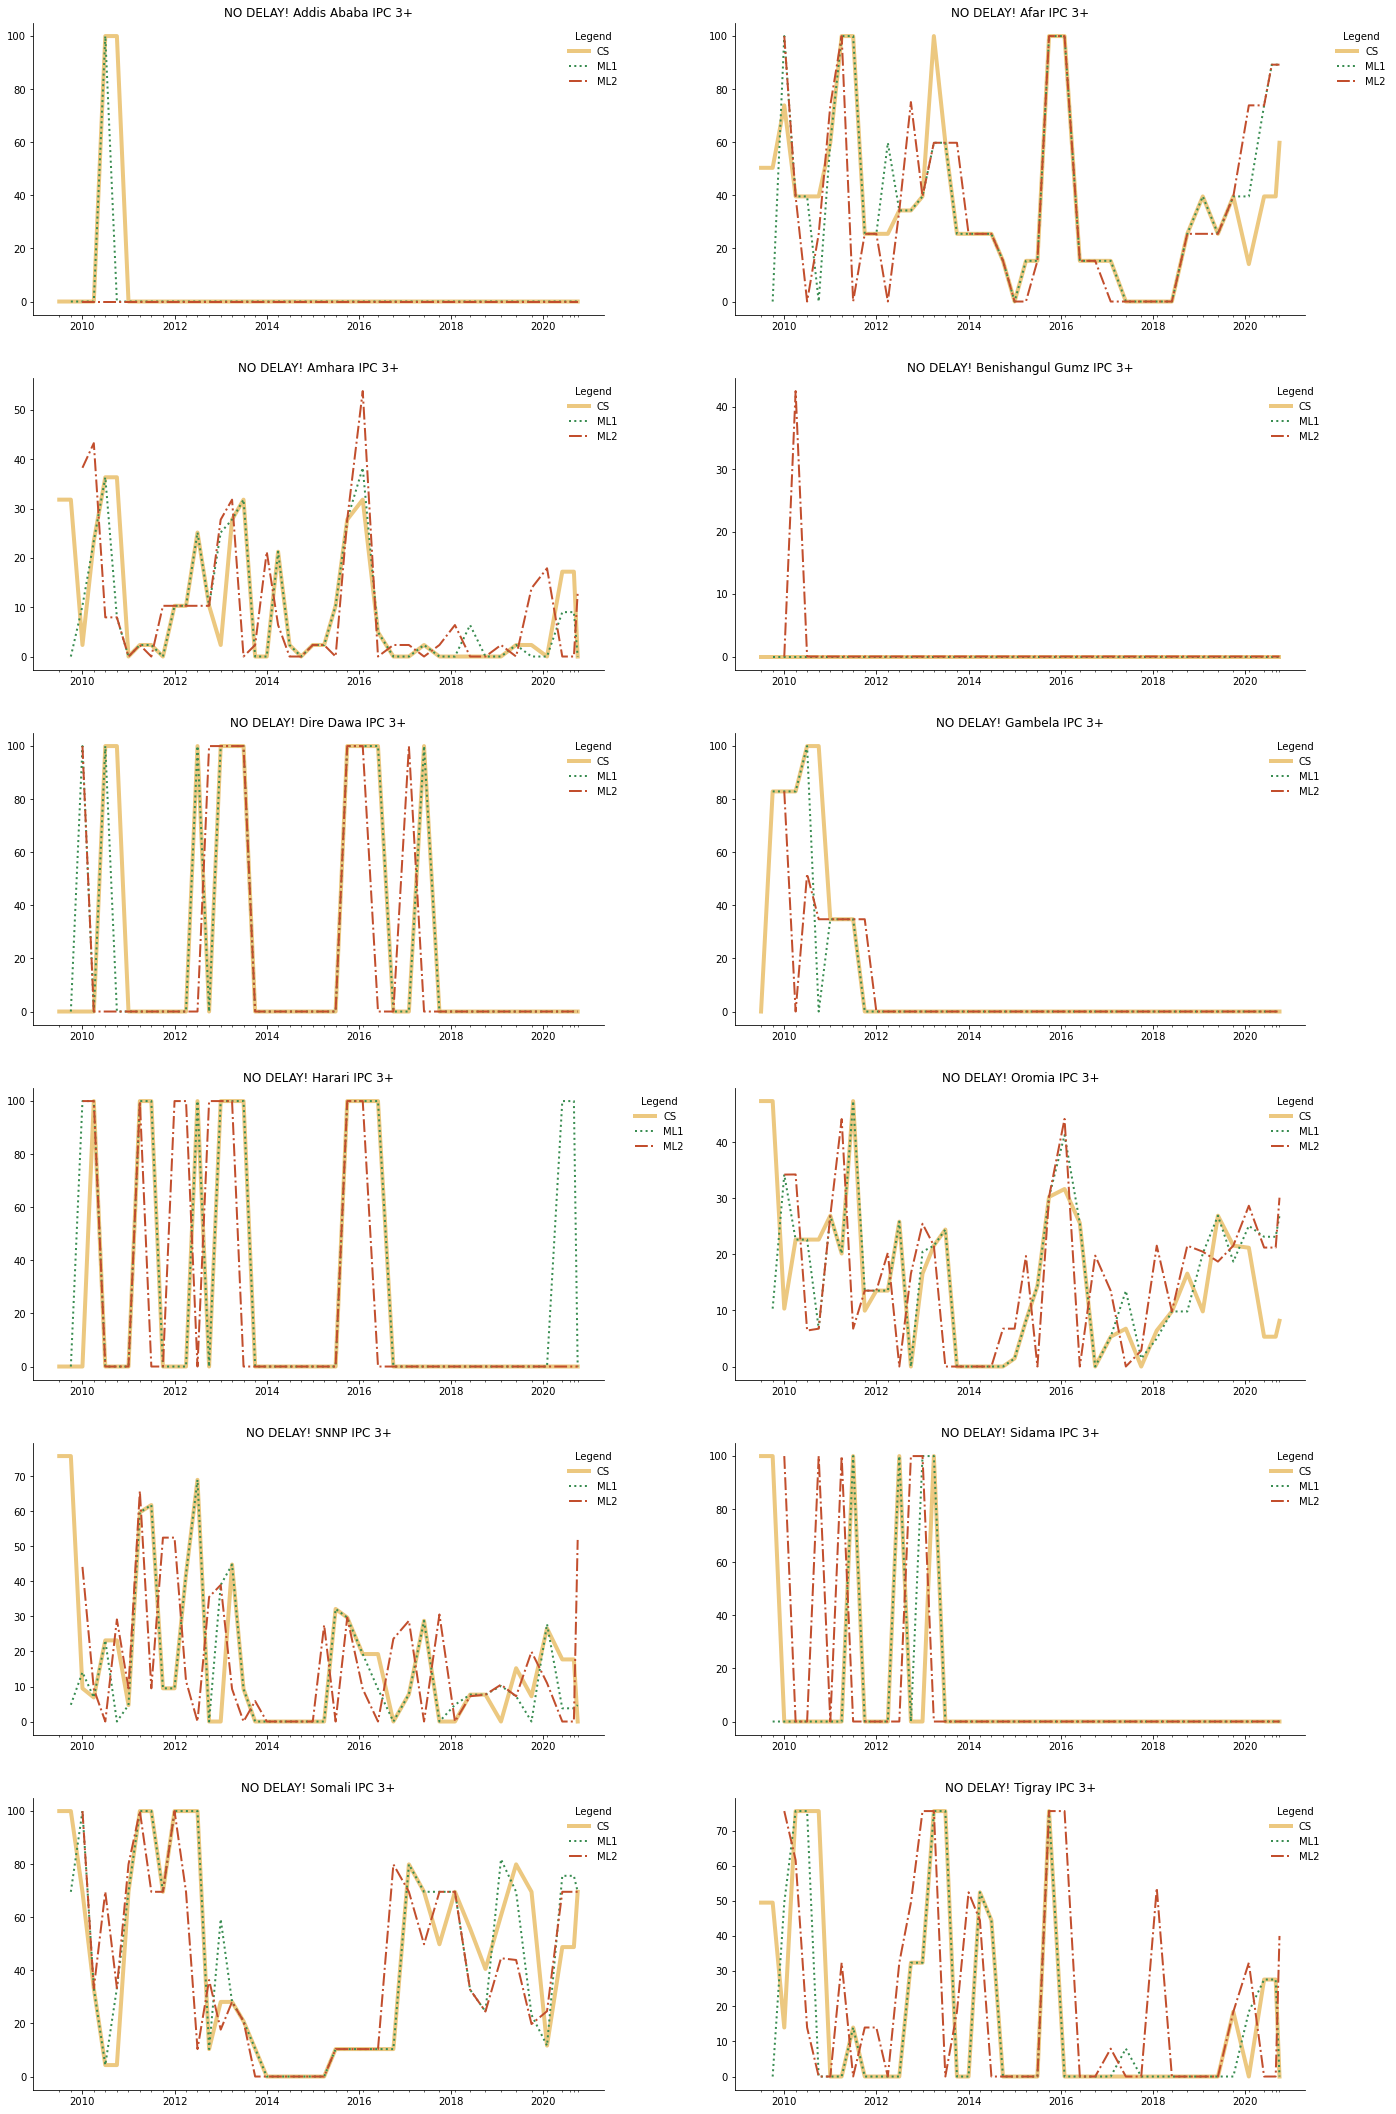

In [57]:
plot_preds_nodelay(df_fadm)

In [58]:
df_fnat[f"ML1_i"]=(df_fnat["perc_ML1_3p"]-df_fnat["perc_CS_3p"])
df_fnat[f"ML2_i"]=(df_fnat["perc_ML2_3p"]-df_fnat["perc_CS_3p"])

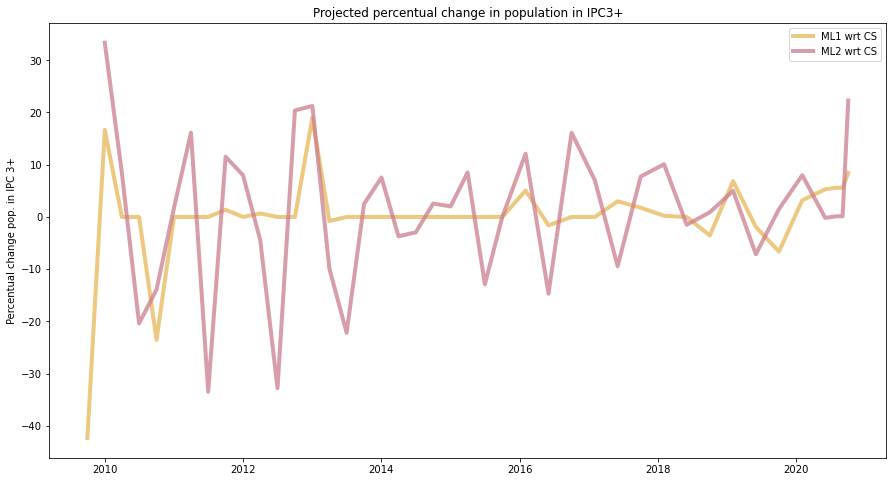

In [59]:
plt.figure(figsize=(15, 8))
plt.ticklabel_format(style='plain', axis='y')
plt.plot(df_fnat['date'], df_fnat['ML1_i'], label='ML1 wrt CS',
                 alpha=0.75, color='#E6B655', linestyle='-', linewidth=4)
plt.plot(df_fnat['date'], df_fnat['ML2_i'], label='ML2 wrt CS',
                 alpha=0.75, color='#CA7E8D', linestyle='-', linewidth=4)
plt.ylabel("Percentual change pop. in IPC 3+")
plt.title("Projected percentual change in population in IPC3+")
plt.legend()